# Project 3 - Time Series Analysis - William ELKIESS

### Retail Sales Forecasting

Dataset Description:

(https://www.kaggle.com/datasets/tevecsystems/retail-sales-forecasting/data)

4 columns:

- Date (From 2014-01-01 to 2016-07-31)
- Venda (Sales)
- Estoque (Stock)
- Preco (Price)

The objective is to predict future sales of this Brasilian retailer

We focus on building 2 models to forecast the sales of the last 30 days of this dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.model_selection import KFold, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error

<span style="color: blue; font-size: 30px;">
Exploratory df Analysis
</span>

<span style="color: blue; font-size: 15px;">

- Change columns names / change date to_datetime

- Plot sales over time

- Plot sales for each year

- Plot monthly sales

- Plot the distribution of sales

- Analyse the trend, seasonality and check the distribution of the residuals

- Plot ACF and PACF

- Perform Dickey-Fuller test for stationarity

</span>

In [3]:
df = pd.read_csv("mock_kaggle.csv")

In [4]:
df.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [5]:
df['data'] = pd.to_datetime(df['data'])
df.columns = ['date', 'sales', 'stock', 'price']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    937 non-null    datetime64[ns]
 1   sales   937 non-null    int64         
 2   stock   937 non-null    int64         
 3   price   937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB


In [7]:
df = df.sort_values(by='date')

In [8]:
df.head()

,date,sales,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [9]:
df.tail()

,date,sales,stock,price
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39
936,2016-07-31,183,3642,2.39


In [10]:
df.describe()

,date,sales,stock,price
count,937,937.000000,937.000000,937.000000
mean,2015-04-19 12:23:49.242262528,90.533618,1608.258271,1.592572
min,2014-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2014-08-29 00:00:00,33.000000,794.000000,1.290000
50%,2015-04-20 00:00:00,76.000000,1348.000000,1.390000
75%,2015-12-10 00:00:00,127.000000,1964.000000,1.890000
max,2016-07-31 00:00:00,542.000000,7228.000000,2.980000
std,NaN,80.682089,1356.691877,0.529502


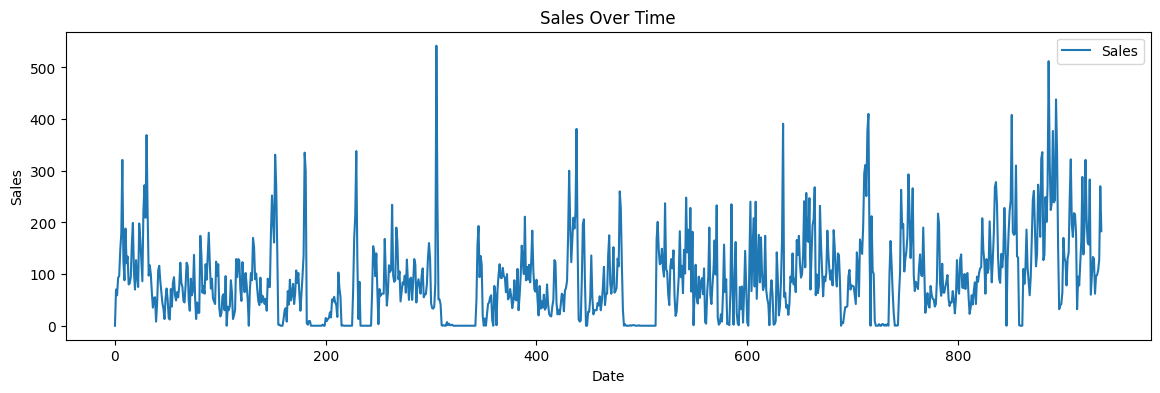

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['sales'], label="Sales")
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

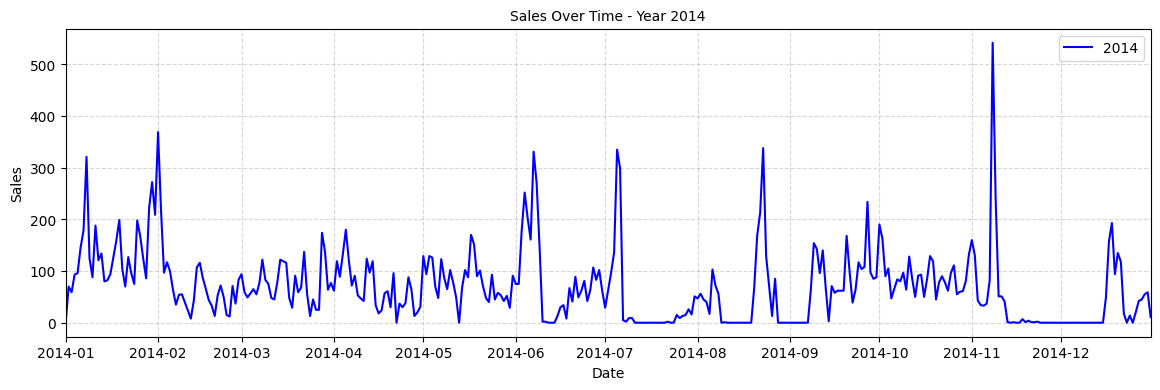

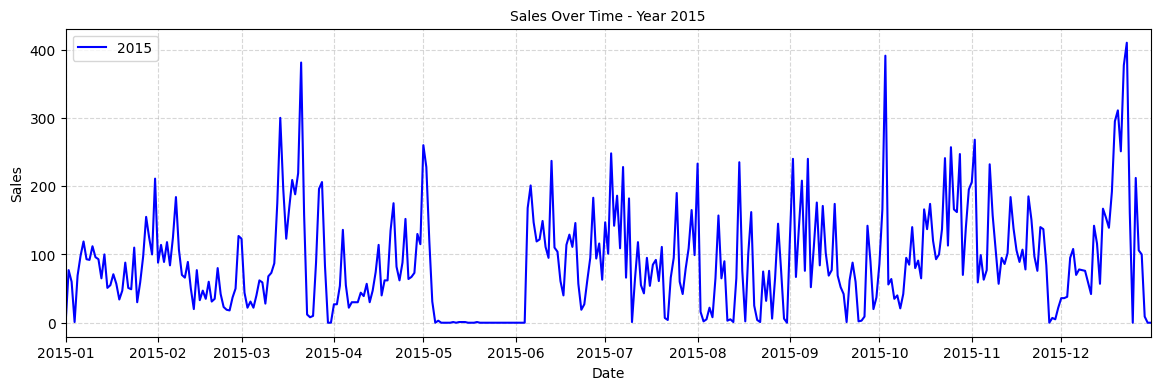

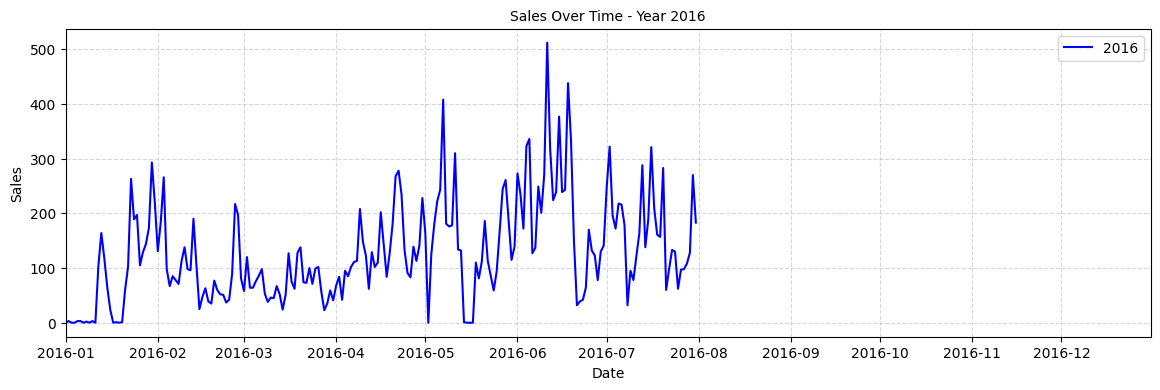

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

years = df['year'].unique()

for year in years:
    yearly_data = df[df['year'] == year]
    
    plt.figure(figsize=(14, 4))
    plt.plot(yearly_data['date'], yearly_data['sales'], label= year, color="blue")

    start_date = yearly_data['date'].min()
    end_date = pd.to_datetime(f"{year}-12-31")
    plt.xlim(start_date, end_date)
    
    plt.title(f"Sales Over Time - Year {year}", fontsize=10)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Sales", fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

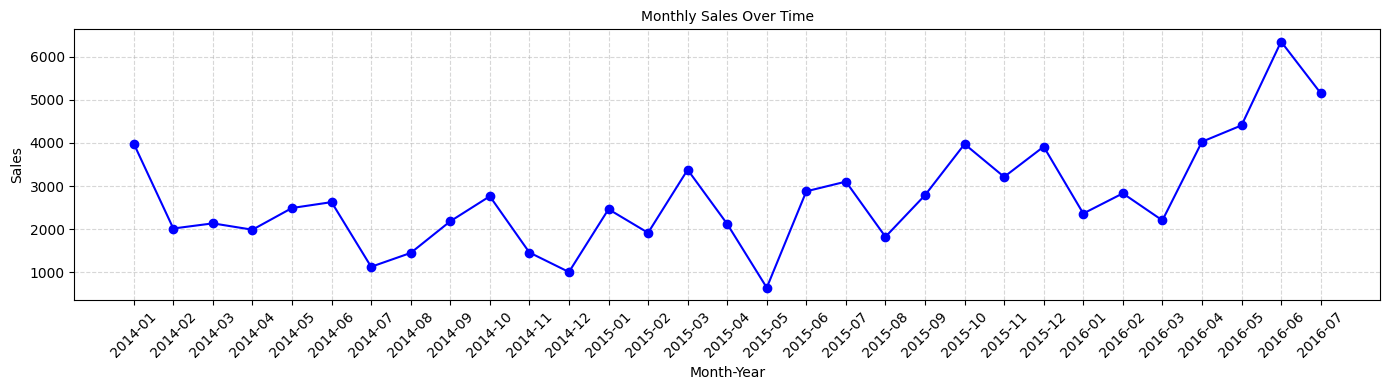

In [13]:
monthly_sales = df.groupby(['year', 'month']).agg({'sales': 'sum'}).reset_index()
monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 4))
plt.plot(monthly_sales['year_month'], monthly_sales['sales'], marker='o', color='blue')

plt.title("Monthly Sales Over Time", fontsize=10)
plt.xlabel("Month-Year", fontsize=10)
plt.ylabel("Sales", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 


plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    937 non-null    datetime64[ns]
 1   sales   937 non-null    int64         
 2   stock   937 non-null    int64         
 3   price   937 non-null    float64       
 4   year    937 non-null    int32         
 5   month   937 non-null    int32         
 6   day     937 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2)
memory usage: 40.4 KB


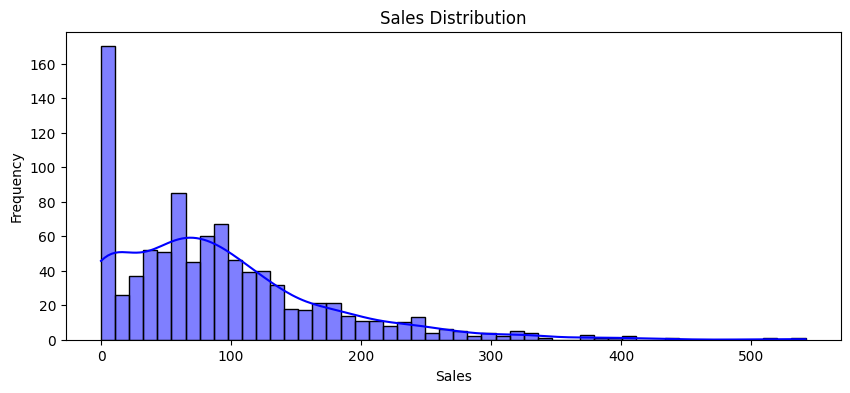

In [15]:
plt.figure(figsize=(10, 4))
sns.histplot(df['sales'], bins=50, kde=True, color="blue")
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()


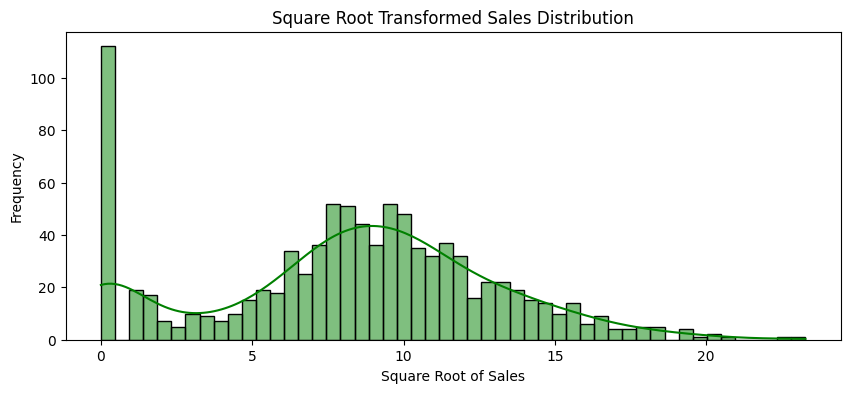

In [16]:
df['sqrt_sales'] = np.sqrt(df['sales'])

plt.figure(figsize=(10, 4))
sns.histplot(df['sqrt_sales'], bins=50, kde=True, color="green")
plt.title("Square Root Transformed Sales Distribution")
plt.xlabel("Square Root of Sales")
plt.ylabel("Frequency")
plt.show()


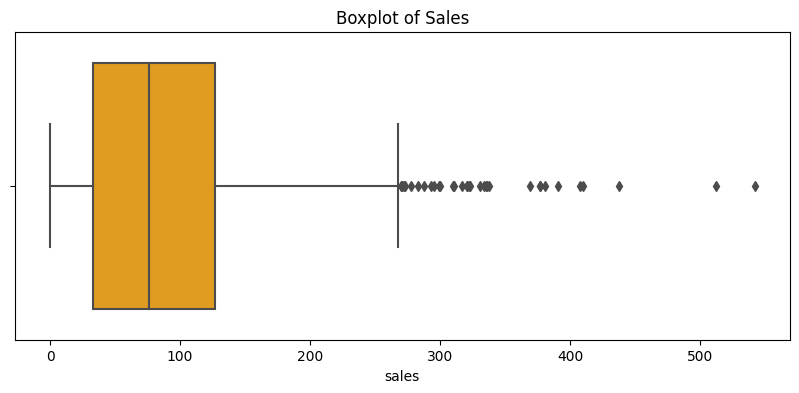

In [17]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['sales'], color="orange")
plt.title("Boxplot of Sales")
plt.show()

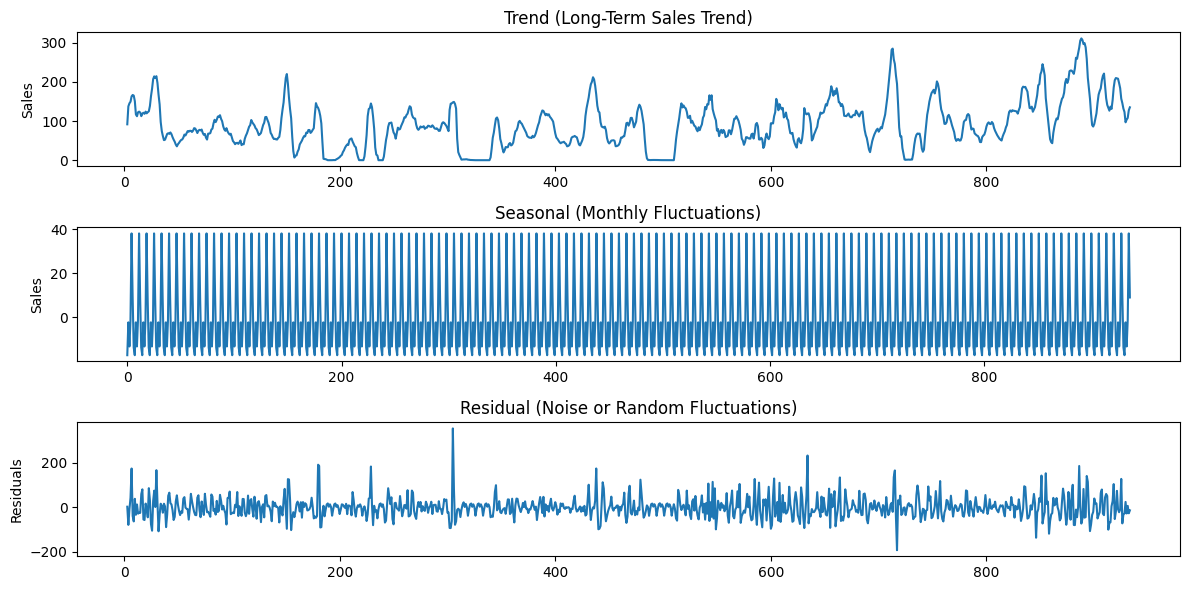

In [18]:
decomposition = seasonal_decompose(df['sales'], model='additive', period=7)

fig, axes = plt.subplots(3, 1, figsize=(12, 6))

axes[0].plot(decomposition.trend)
axes[0].set_title("Trend (Long-Term Sales Trend)")
axes[0].set_ylabel("Sales")

axes[1].plot(decomposition.seasonal)
axes[1].set_title("Seasonal (Monthly Fluctuations)")
axes[1].set_ylabel("Sales")

axes[2].plot(decomposition.resid)
axes[2].set_title("Residual (Noise or Random Fluctuations)")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

<span style="color: blue; font-size: 15px;">

The data clearly displays some seasonality but no trend.

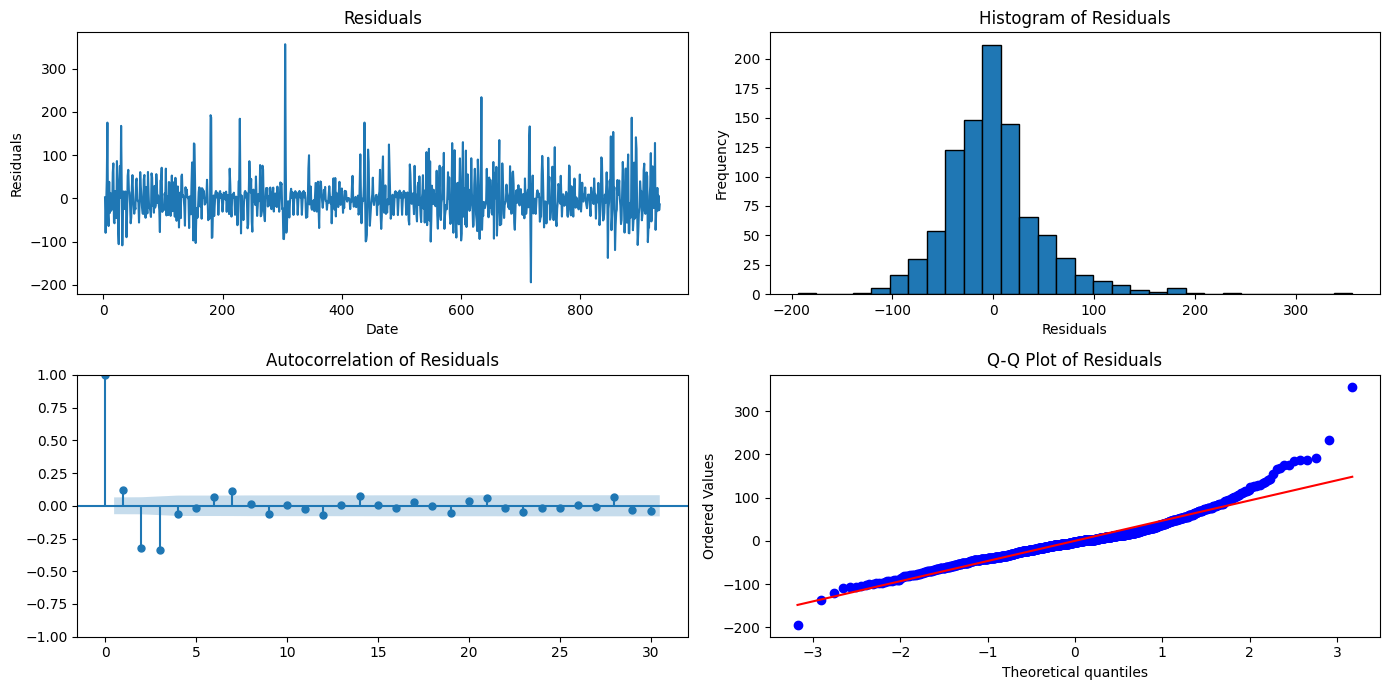

In [19]:
residuals = decomposition.resid

fig, axs = plt.subplots(2, 2, figsize=(14, 7))

axs[0, 0].plot(residuals)
axs[0, 0].set_title('Residuals')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Residuals')

axs[0, 1].hist(residuals.dropna(), bins=30, edgecolor='black')
axs[0, 1].set_title('Histogram of Residuals')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Frequency')

plot_acf(residuals.dropna(), lags=30, ax=axs[1, 0])
axs[1, 0].set_title('Autocorrelation of Residuals')

stats.probplot(residuals.dropna(), dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()


<span style="color: blue; font-size: 15px;">

The residuals appear to be a bit squewed but not terrible 

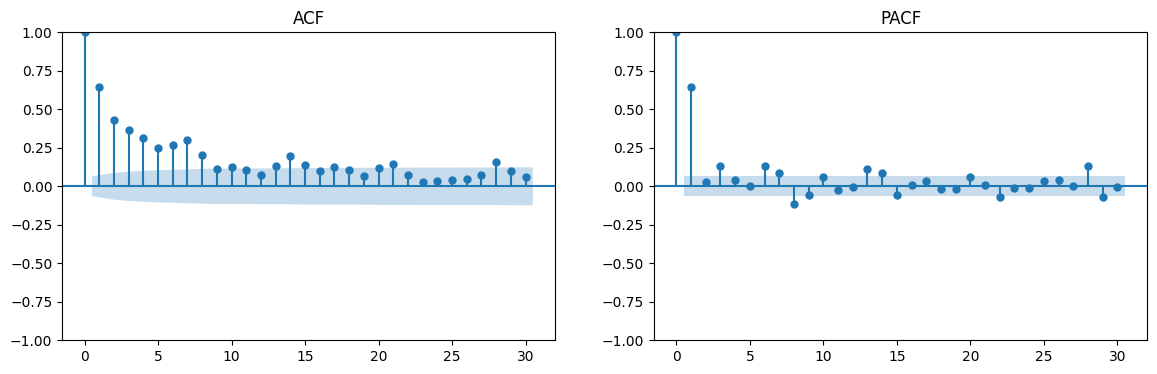

In [20]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plot_acf(df['sales'], lags=30, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(df['sales'], lags=30, ax=plt.gca())
plt.title('PACF')

plt.show()

<span style="color: blue; font-size: 15px;">

The ACf plot displays spikes until lag 8 while the PACF only displays one spike

In this case it appears that we have a weekly seasonal time series with both autoregressive behavior and seasonal components

We will build a SARIMA model later

In [21]:
adf_result = adfuller(df['sales'].dropna()) 

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

ADF Statistic: -5.326902281189402
p-value: 4.815089201365864e-06
Critical Values: {'1%': -3.437462363899248, '5%': -2.8646798473884134, '10%': -2.568441851017076}


<span style="color: blue; font-size: 15px;">

The p-value < 0.05, we can reject the null hypothesis, therefore the data is stationary

<span style="color: blue; font-size: 30px;">

Models

<span style="color: blue; font-size: 15px;">

Build 2 models to predict the sales of the last month:

- SARIMA
- XGBoost with GridSearchCV to find the best hyperparameters

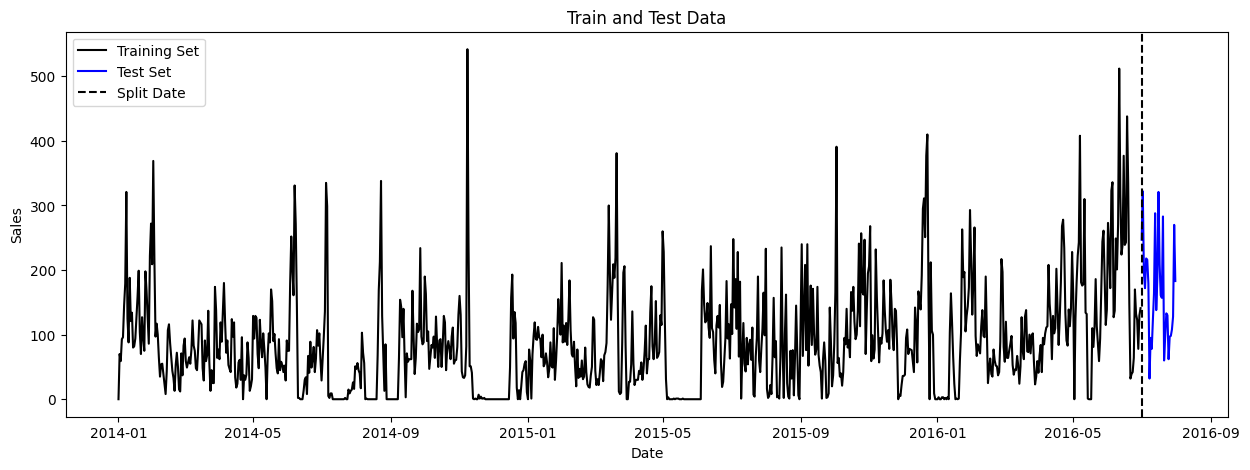

In [22]:
train = df[df['date'] < '2016-07-01']
test = df[df['date'] >= '2016-07-01']

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['date'], train['sales'], label='Training data', color ='black')
ax.plot(test['date'], test['sales'], label='Test data', color ='blue')

ax.axvline(pd.Timestamp('2016-07-01'), color='black', ls='--')

ax.set_title('Train and Test Data')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend(['Training Set', 'Test Set', 'Split Date'])

plt.show()

<span style="color: blue; font-size: 15px;">

We split the data in order to have the test data only for the last 30 days

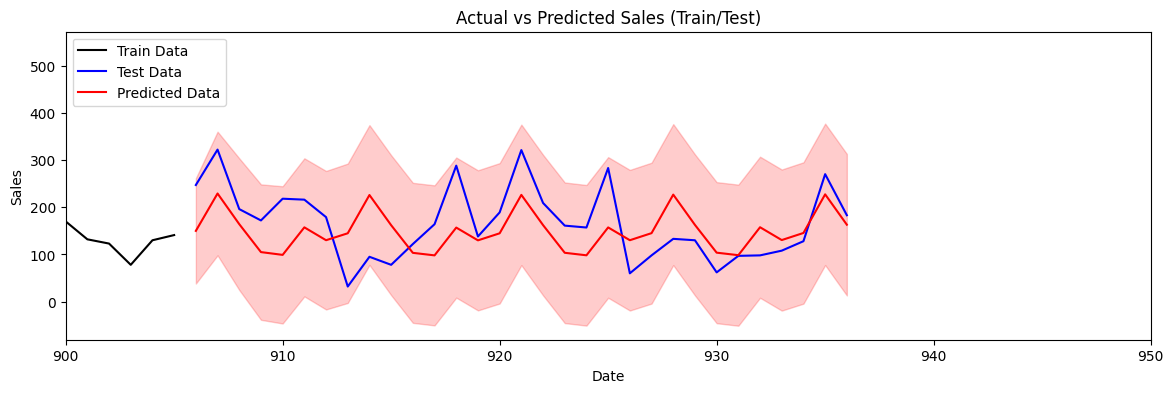

In [23]:
sarima_model = SARIMAX(train['sales'], 
                       order=(1, 0, 1), 
                       seasonal_order=(1, 0, 1, 7), #here 7 indicates the seasonal components of 7 days
                       enforce_stationarity=False, enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

pred = sarima_result.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

plt.figure(figsize=(14, 4))
plt.plot(train.index, train['sales'], label='Train Data', color ='black')
plt.plot(test.index, test['sales'], label='Test Data', color='blue')
plt.plot(pred_mean.index, pred_mean, label='Predicted Data', color='red')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='red', alpha=0.2)

plt.xlim(900, 950)

plt.legend(loc='upper left')
plt.title('Actual vs Predicted Sales (Train/Test)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [24]:
test['prediction'] = pred_mean
score_sarimax = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE: {score_sarimax:0.2f}')

RMSE: 72.62


<span style="color: blue; font-size: 15px;">

The RMSE of the SARIMA model is around 72

In [25]:
def create_features(df):
    df = df.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

df = create_features(df)

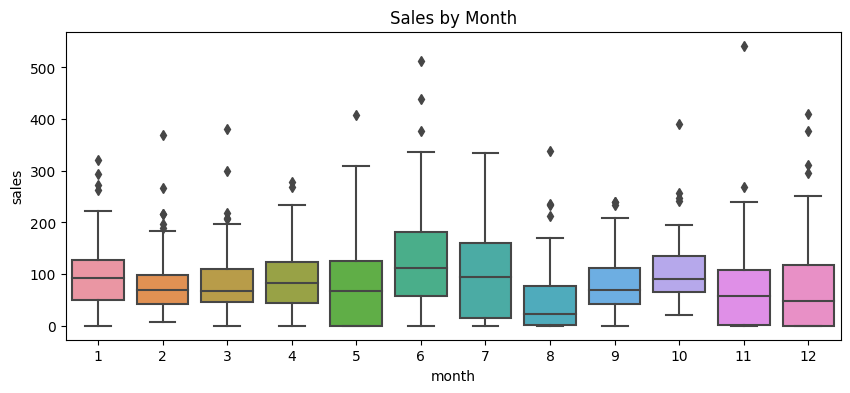

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x='month', y='sales')
ax.set_title('Sales by Month')
plt.show()

In [27]:
train = create_features(train)
test = create_features(test)

variables = ['price', 'stock', 'dayofyear', 'dayofweek', 'month', 'year']
target = 'sales'

X_train = train[variables]
y_train = train[target]

X_test = test[variables]
y_test = test[target]

In [28]:
def trainmodel_with_eval(model, parameters, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        refit=True,
        cv=KFold(shuffle=True, random_state=6),
        n_jobs=-1
    )

    grid_fit = grid.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=100
    )

    best_model = grid_fit.best_estimator_
    
    print(f"Best parameters: {grid_fit.best_params_}")
    
    return best_model

In [29]:
xgb_parameters = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [1, 3, 5, 7],
}


In [30]:
reg = trainmodel_with_eval(
    xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        objective='reg:squarederror',
        random_state=6
    ),
    xgb_parameters,
    X_train,
    y_train,
    X_test,
    y_test
)

[0]	validation_0-rmse:110.82042	validation_1-rmse:171.85215
[100]	validation_0-rmse:46.25908	validation_1-rmse:62.29554
[200]	validation_0-rmse:38.17994	validation_1-rmse:55.26254
[280]	validation_0-rmse:33.49664	validation_1-rmse:54.51532
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


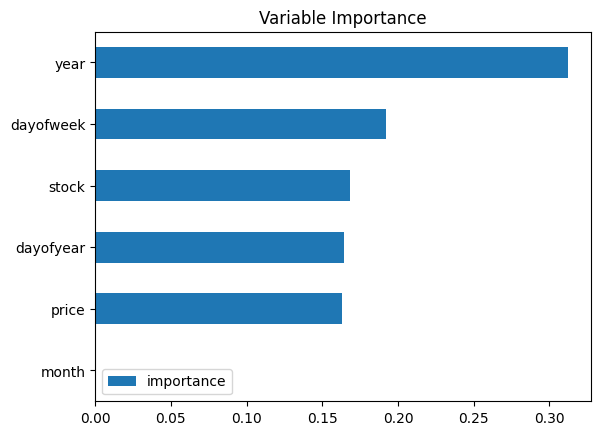

In [31]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Variable Importance')
plt.show()

In [32]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

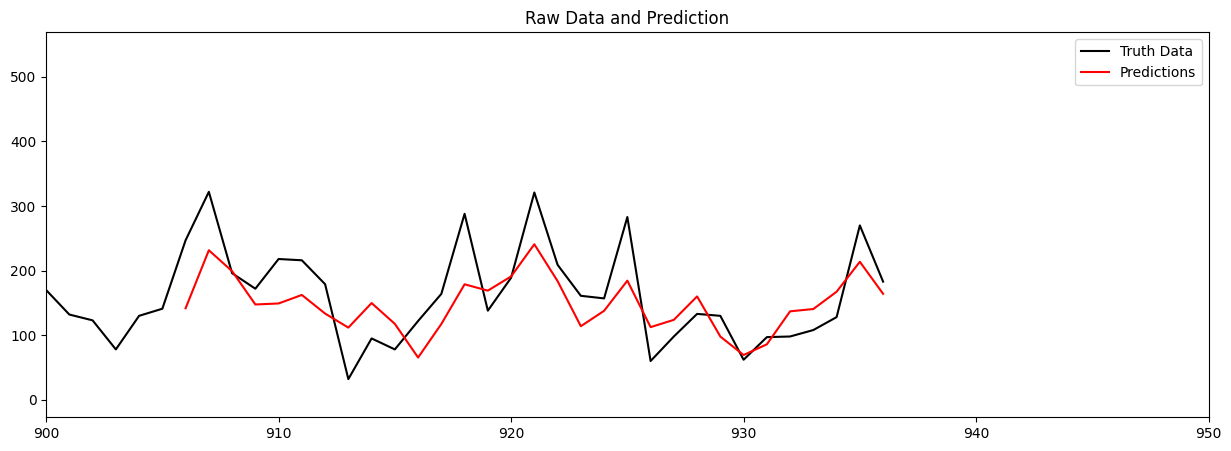

In [33]:
ax = df[['sales']].plot(figsize=(15, 5), label='True Data', color ='black')
df['prediction'].plot(ax=ax, label='Predictions', color ='red')

plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.xlim(900, 950)
plt.show()

In [34]:
score_xgb = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE: {score_xgb:0.2f}')

RMSE: 54.22


<span style="color: blue; font-size: 15px;">

Overall the XGBoost model performs better than the SARIMA, with an RMSE of around 54. As displayed on the graph above, the predictions follows the data.